In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Renault.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Clio,Seri_Fluence,Seri_Grand Scenic,...,Model_TS,Model_TSW,Model_TX,Model_Toros,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,245000,-0.545455,-1.027778,-0.475962,2.830262,3.0,0.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,499000,0.454545,-0.333333,-0.475962,-0.374532,NaN,NaN,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,235000,-0.636364,-0.611111,-0.475962,0.486891,6.0,1.0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,345000,-0.181818,-0.055556,-0.475962,-0.194757,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,817500,0.909091,0.361111,-0.475962,-0.752584,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_14940\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,48547.323039,1.718177e+09,41450.903911,30154.238716


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:25:16,553] A new study created in memory with name: no-name-256082fa-9ca2-4820-b066-cd552b549c9d
[I 2023-05-23 21:25:16,828] Trial 4 finished with value: 152688.1983383598 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1339238624852773, 'max_depth': 3, 'min_child_weight': 281}. Best is trial 4 with value: 152688.1983383598.
[I 2023-05-23 21:25:16,859] Trial 5 finished with value: 99337.08379338816 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.2011694259074997, 'max_depth': 6, 'min_child_weight': 253}. Best is trial 5 with value: 99337.08379338816.
[I 2023-05-23 21:25:16,861] Trial 7 finished with value: 437621.02936777665 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.0014723162155141551, 'max_depth': 12, 'min_child_weight': 198}. Best is trial 5 with value: 99337.08379338816.
[I 2023-05-23 21:25:16,945] Trial 3 finished with value: 186592.05270258052 and parameters: {'cols

[I 2023-05-23 21:25:18,539] Trial 32 finished with value: 363631.52948628174 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.020656120639501764, 'max_depth': 13, 'min_child_weight': 6}. Best is trial 28 with value: 49262.31007196236.
[I 2023-05-23 21:25:18,576] Trial 29 finished with value: 51240.48049683334 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.4227942596794269, 'max_depth': 13, 'min_child_weight': 4}. Best is trial 28 with value: 49262.31007196236.
[I 2023-05-23 21:25:18,577] Trial 31 finished with value: 53045.74687487671 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.49200868023352934, 'max_depth': 13, 'min_child_weight': 5}. Best is trial 28 with value: 49262.31007196236.
[I 2023-05-23 21:25:18,613] Trial 34 finished with value: 124422.91242301033 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.13149528090648638, 'max_depth': 14, 'min_child_weight'

[I 2023-05-23 21:25:20,462] Trial 60 finished with value: 46810.95677940112 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.3218498363481249, 'max_depth': 14, 'min_child_weight': 15}. Best is trial 60 with value: 46810.95677940112.
[I 2023-05-23 21:25:20,530] Trial 61 finished with value: 48662.05898620089 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.28024115411558936, 'max_depth': 15, 'min_child_weight': 16}. Best is trial 60 with value: 46810.95677940112.
[I 2023-05-23 21:25:20,548] Trial 62 finished with value: 46789.77138803617 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.32824621785532726, 'max_depth': 14, 'min_child_weight': 19}. Best is trial 62 with value: 46789.77138803617.
[I 2023-05-23 21:25:20,690] Trial 63 finished with value: 64332.06889557295 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.32436555671579004, 'max_depth': 14, 'min_child_weight'

[I 2023-05-23 21:25:22,867] Trial 90 finished with value: 48096.395101943956 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.41309673896286725, 'max_depth': 13, 'min_child_weight': 60}. Best is trial 69 with value: 46148.16523495432.
[I 2023-05-23 21:25:22,908] Trial 92 finished with value: 48686.27766260888 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.49130375049604147, 'max_depth': 13, 'min_child_weight': 13}. Best is trial 69 with value: 46148.16523495432.
[I 2023-05-23 21:25:22,921] Trial 91 finished with value: 54199.18954784276 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.49970449022027713, 'max_depth': 13, 'min_child_weight': 12}. Best is trial 69 with value: 46148.16523495432.
[I 2023-05-23 21:25:23,012] Trial 94 finished with value: 71128.43331776425 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.49438762702761485, 'max_depth': 13, 'min_child_weigh

[I 2023-05-23 21:25:25,163] Trial 121 finished with value: 49697.56533859246 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.30874949431575305, 'max_depth': 13, 'min_child_weight': 91}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:25,195] Trial 120 finished with value: 50999.078085611596 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2984348121470589, 'max_depth': 13, 'min_child_weight': 98}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:25,264] Trial 122 finished with value: 47915.31486201185 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.30928107158709783, 'max_depth': 13, 'min_child_weight': 72}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:25,285] Trial 123 finished with value: 49139.42068271358 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.2913676226837699, 'max_depth': 13, 'min_chi

[I 2023-05-23 21:25:27,416] Trial 151 finished with value: 46580.34151318043 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.37940082949799897, 'max_depth': 11, 'min_child_weight': 54}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:27,528] Trial 149 finished with value: 46580.63179739821 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4905140138318135, 'max_depth': 11, 'min_child_weight': 40}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:27,529] Trial 153 finished with value: 46312.93991911872 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.353994270670556, 'max_depth': 11, 'min_child_weight': 50}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:27,535] Trial 152 finished with value: 46573.46475843758 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.357724171484542, 'max_depth': 11, 'min_child_w

[I 2023-05-23 21:25:29,706] Trial 179 finished with value: 47688.829806721566 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4269458605359335, 'max_depth': 13, 'min_child_weight': 59}. Best is trial 109 with value: 44961.539922126016.
[I 2023-05-23 21:25:29,738] Trial 182 finished with value: 44925.22386725126 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3811693884361192, 'max_depth': 13, 'min_child_weight': 42}. Best is trial 182 with value: 44925.22386725126.
[I 2023-05-23 21:25:29,739] Trial 183 finished with value: 46869.58734848791 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.42816365197916706, 'max_depth': 13, 'min_child_weight': 60}. Best is trial 182 with value: 44925.22386725126.
[I 2023-05-23 21:25:29,745] Trial 181 finished with value: 44989.100215795246 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.3911175423241573, 'max_depth': 13, 'min_child

[I 2023-05-23 21:25:32,359] Trial 212 finished with value: 52614.123065661246 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.27442060808278707, 'max_depth': 12, 'min_child_weight': 24}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:32,360] Trial 210 finished with value: 51048.96878787157 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.3026689812688162, 'max_depth': 12, 'min_child_weight': 23}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:32,461] Trial 213 finished with value: 48880.85325574313 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.30083325792560633, 'max_depth': 12, 'min_child_weight': 26}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:32,592] Trial 215 finished with value: 47447.14586527809 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.28513449335959484, 'max_depth': 12, 'min_child

[I 2023-05-23 21:25:34,903] Trial 240 finished with value: 46842.92515967322 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4665030266873738, 'max_depth': 13, 'min_child_weight': 48}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:34,996] Trial 241 finished with value: 45875.219322571174 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.46854631113200085, 'max_depth': 13, 'min_child_weight': 47}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:35,032] Trial 242 finished with value: 384452.17299161875 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014604369442186512, 'max_depth': 13, 'min_child_weight': 49}. Best is trial 194 with value: 43985.85074252886.
[I 2023-05-23 21:25:35,060] Trial 244 finished with value: 384719.9302644856 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014463663170749796, 'max_depth': 13, 'min_ch

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 43985.8507
Best params:
	colsample_bytree: 0.8
	subsample: 1.0
	learning_rate: 0.36093285390521923
	max_depth: 14
	min_child_weight: 33


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [9,14],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.8],
               'subsample': [1],
               'min_child_weight': [33]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 33, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 51290.83113146204, 'MSE': 1991390317.7327027, 'RMSE': 44624.99655722903, 'MAE': 32050.699977992957}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9490647978281554

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9420138504200696

In [17]:
marka_model = joblib.dump(grid_final_model, "Renault.pkl")

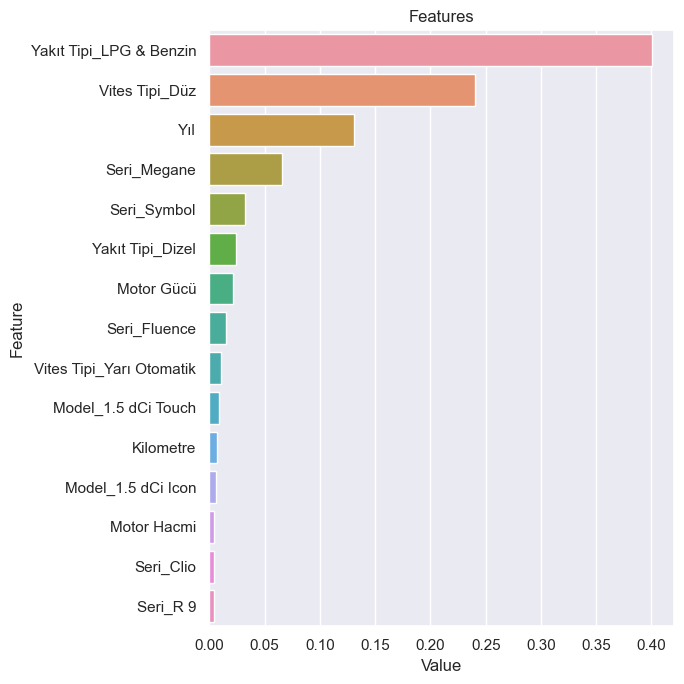

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)